In [1]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
import torch
import numpy as np
import time
import csv

# Load the Quora dataset
print("Loading Quora Question Pairs dataset...")
try:
    dataset = load_dataset("quora", split="train")
except:
    dataset = load_dataset("SetFit/quora", split="train")

print(f"Loaded {len(dataset)} question pairs")

# Extract sentences and labels (first 1500 samples)
sentences1 = []
sentences2 = []
ground_truth_labels = []

for i in range(min(1500, len(dataset))):
    item = dataset[i]
    if len(item['questions']['text']) >= 2:
        sentences1.append(item['questions']['text'][0])
        sentences2.append(item['questions']['text'][1])
        ground_truth_labels.append(item['is_duplicate'])

print(f"Dataset loaded: {len(sentences1)} sentence pairs")

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model configurations
MODEL_CONFIGS = {
    "all-MiniLM": {
        "type": "sentence_transformer",
        "model_name": "all-MiniLM-L6-v2"
    },
    "all-mpnet": {
        "type": "sentence_transformer",
        "model_name": "all-mpnet-base-v2"
    },
    "gtr-t5-base": {
        "type": "sentence_transformer",
        "model_name": "sentence-transformers/gtr-t5-base"
    },
    "bert-pro": {
        "type": "encoder",
        "model_name": "boltuix/bert-pro"
    },
    "roberta-base": {
        "type": "encoder",
        "model_name": "roberta-base"
    },
    "distilbert": {
        "type": "encoder",
        "model_name": "distilbert-base-uncased"
    },
    "gpt2-small": {
        "type": "decoder",
        "model_name": "gpt2"
    },
    "phi-4-mini": {
        "type": "decoder",
        "model_name": "microsoft/Phi-4-mini-reasoning"
    },
    "qwen2-small": {
        "type": "decoder",
        "model_name": "Qwen/Qwen2-0.5B"
    },
    "tinyllama": {
        "type": "decoder",
        "model_name": "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    }
}

class ModelEvaluator:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
    
    def get_sentence_transformer_embeddings(self, model_name, sentences):
        """Get embeddings using SentenceTransformer models"""
        model = SentenceTransformer(model_name)
        embeddings = model.encode(sentences, batch_size=self.batch_size, show_progress_bar=True)
        return embeddings
    
    def get_encoder_embeddings(self, model_name, sentences):
        """Get embeddings using encoder models (BERT, RoBERTa, etc.)"""
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device)
        model.eval()
        
        all_embeddings = []
        
        for i in range(0, len(sentences), self.batch_size):
            batch_sentences = sentences[i:i + self.batch_size]
            
            # Tokenize
            tokens = tokenizer(
                batch_sentences,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)
            
            # Get embeddings
            with torch.no_grad():
                outputs = model(**tokens)
                # Use mean pooling of last hidden states
                embeddings = outputs.last_hidden_state.mean(dim=1)
                all_embeddings.extend(embeddings.cpu().numpy())
        
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        return np.array(all_embeddings)
    
    def get_decoder_embeddings(self, model_name, sentences):
        """Get embeddings using decoder models (GPT-2, etc.)"""
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device)
        model.eval()
        
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        all_embeddings = []
        
        for i in range(0, len(sentences), self.batch_size):
            batch_sentences = sentences[i:i + self.batch_size]
            
            tokens = tokenizer(
                batch_sentences,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**tokens, output_hidden_states=True)
                hidden_states = outputs.hidden_states[-1]
                
                # Get last non-padding token embedding for each sentence
                batch_embeddings = []
                for j, input_ids in enumerate(tokens['input_ids']):
                    non_pad_mask = input_ids != tokenizer.pad_token_id
                    last_token_idx = non_pad_mask.sum() - 1
                    embedding = hidden_states[j, last_token_idx]
                    batch_embeddings.append(embedding.cpu().numpy())
                
                all_embeddings.extend(batch_embeddings)
        
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        return np.array(all_embeddings)
    
    def evaluate_model(self, model_key, model_config):
        """Evaluate a single model"""
        print(f"\nEvaluating: {model_key}")
        start_time = time.time()
        
        try:
            model_type = model_config["type"]
            model_name = model_config["model_name"]
            
            # Get embeddings based on model type
            if model_type == "sentence_transformer":
                embeddings1 = self.get_sentence_transformer_embeddings(model_name, sentences1)
                embeddings2 = self.get_sentence_transformer_embeddings(model_name, sentences2)
            elif model_type == "encoder":
                embeddings1 = self.get_encoder_embeddings(model_name, sentences1)
                embeddings2 = self.get_encoder_embeddings(model_name, sentences2)
            elif model_type == "decoder":
                embeddings1 = self.get_decoder_embeddings(model_name, sentences1)
                embeddings2 = self.get_decoder_embeddings(model_name, sentences2)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
            
            # Calculate cosine similarities
            similarities = []
            for i in range(len(embeddings1)):
                similarity = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
                similarities.append(similarity)
            
            # Calculate AUC
            auc_score = roc_auc_score(ground_truth_labels, similarities)
            
            elapsed_time = time.time() - start_time
            
            print(f"  AUC Score: {auc_score:.4f}")
            print(f"  Mean Cosine Similarity: {np.mean(similarities):.4f}")
            print(f"  Time: {elapsed_time:.1f}s")
            
            return {
                'model': model_key,
                'auc_score': auc_score,
                'mean_cosine_similarity': np.mean(similarities),
                'time': elapsed_time
            }
            
        except Exception as e:
            print(f"  Error: {str(e)}")
            return None
    
    def run_comparison(self):
        """Run evaluation on all models"""
        print("\nRunning model comparison...")
        results = []
        
        for model_key, model_config in MODEL_CONFIGS.items():
            result = self.evaluate_model(model_key, model_config)
            if result:
                results.append(result)
            
            # Clear memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Print summary
        print(f"\nResults Summary:")
        print(f"{'Model':<15} {'AUC Score':<10} {'Mean Cosine':<12} {'Time(s)':<8}")
        print("-" * 50)
        
        # Sort by AUC score (descending)
        results.sort(key=lambda x: x['auc_score'], reverse=True)
        
        for result in results:
            print(f"{result['model']:<15} {result['auc_score']:<10.4f} "
                  f"{result['mean_cosine_similarity']:<12.4f} {result['time']:<8.1f}")
        
        return results

# Run the evaluation
if __name__ == "__main__":
    evaluator = ModelEvaluator(batch_size=32)
    results = evaluator.run_comparison()
    
    if results:
        # Save results to CSV
        with open('model_evaluation_results2.csv', 'w', newline='') as csvfile:
            fieldnames = ['model', 'auc_score', 'mean_cosine_similarity', 'time']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for result in results:
                writer.writerow(result)
        
        print(f"\nResults saved to 'model_evaluation_results2.csv'")
        print(f"Completed evaluation of {len(results)} models.")
        
        # Print best model
        best_model = max(results, key=lambda x: x['auc_score'])
        print(f"\nBest performing model: {best_model['model']} (AUC: {best_model['auc_score']:.4f})")
    else:
        print("No successful evaluations completed.")

/home/ajwoods/miniconda3/envs/prompt-learning-research/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Quora Question Pairs dataset...
Loaded 404290 question pairs
Dataset loaded: 1500 sentence pairs
Using device: cuda

Running model comparison...

Evaluating: all-MiniLM


Batches: 100%|██████████| 47/47 [00:00<00:00, 305.14it/s]


  AUC Score: 0.8681
  Mean Cosine Similarity: 0.6711
  Time: 2.1s

Evaluating: all-mpnet


Batches: 100%|██████████| 47/47 [00:00<00:00, 107.75it/s]


  AUC Score: 0.8946
  Mean Cosine Similarity: 0.6634
  Time: 2.6s

Evaluating: gtr-t5-base


Batches: 100%|██████████| 47/47 [00:00<00:00, 106.00it/s]


  AUC Score: 0.8787
  Mean Cosine Similarity: 0.7971
  Time: 3.6s

Evaluating: bert-pro


Some weights of BertModel were not initialized from the model checkpoint at boltuix/bert-pro and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at boltuix/bert-pro and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  AUC Score: 0.7512
  Mean Cosine Similarity: 0.9379
  Time: 2.4s

Evaluating: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  AUC Score: 0.5799
  Mean Cosine Similarity: 0.9641
  Time: 5.5s

Evaluating: distilbert
  AUC Score: 0.7615
  Mean Cosine Similarity: 0.9015
  Time: 1.7s

Evaluating: gpt2-small
  AUC Score: 0.6454
  Mean Cosine Similarity: 0.9979
  Time: 2.2s

Evaluating: phi-4-mini


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


  AUC Score: 0.6233
  Mean Cosine Similarity: 0.6604
  Time: 39.1s

Evaluating: qwen2-small
  AUC Score: 0.7329
  Mean Cosine Similarity: 0.9243
  Time: 8.8s

Evaluating: tinyllama
  AUC Score: 0.7313
  Mean Cosine Similarity: 0.8636
  Time: 26.2s

Results Summary:
Model           AUC Score  Mean Cosine  Time(s) 
--------------------------------------------------
all-mpnet       0.8946     0.6634       2.6     
gtr-t5-base     0.8787     0.7971       3.6     
all-MiniLM      0.8681     0.6711       2.1     
distilbert      0.7615     0.9015       1.7     
bert-pro        0.7512     0.9379       2.4     
qwen2-small     0.7329     0.9243       8.8     
tinyllama       0.7313     0.8636       26.2    
gpt2-small      0.6454     0.9979       2.2     
phi-4-mini      0.6233     0.6604       39.1    
roberta-base    0.5799     0.9641       5.5     

Results saved to 'model_evaluation_results2.csv'
Completed evaluation of 10 models.

Best performing model: all-mpnet (AUC: 0.8946)


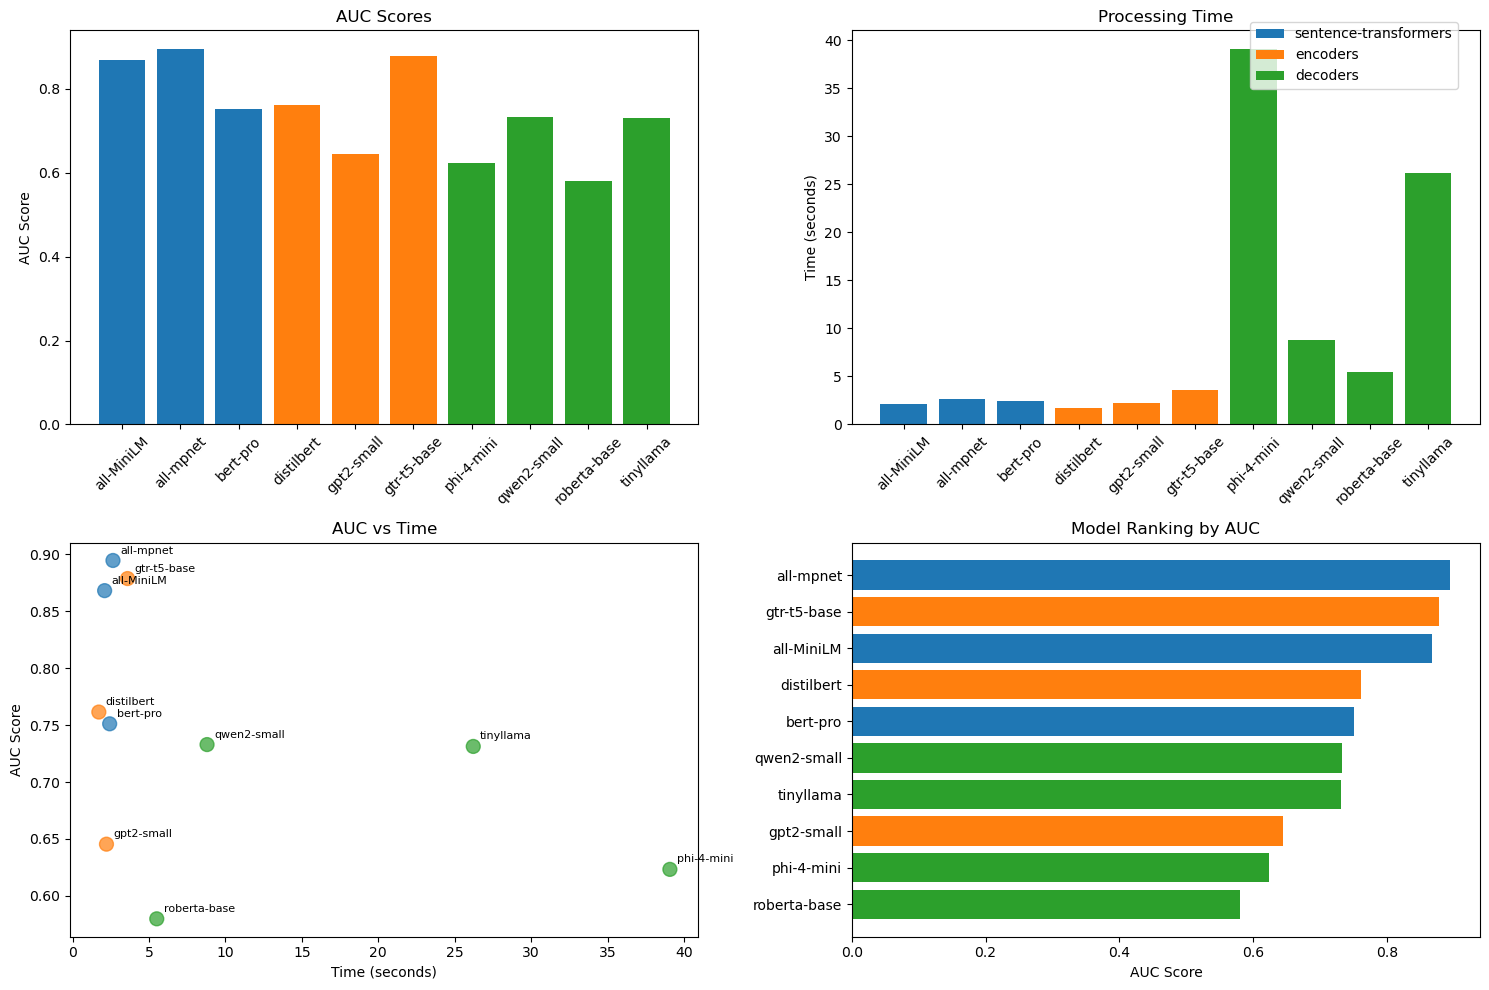

Best model: all-mpnet (AUC: 0.8946)
Fastest model: distilbert (1.7s)


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# Read the CSV file
df = pd.read_csv('model_evaluation_results2.csv')

# Sort dataframe by model name for consistent ordering
df = df.sort_values('model').reset_index(drop=True)

# Create architecture groups
def get_architecture(index):
    if index < 3:
        return 'sentence-transformers'
    elif index < 6:
        return 'encoders'
    else:
        return 'decoders'

# Add architecture column
df['architecture'] = [get_architecture(i) for i in range(len(df))]

# Define colors for each architecture (red, green, blue)
architecture_colors = {
    'sentence-transformers': '#1f77b4',  # Blue
    'encoders': '#ff7f0e',              # Orange  
    'decoders': '#2ca02c'               # Green
}

# Create color mapping for each model based on architecture
model_colors = {model: architecture_colors[arch] 
                for model, arch in zip(df['model'], df['architecture'])}

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. AUC Scores
bar_colors = [model_colors[model] for model in df['model']]
ax1.bar(df['model'], df['auc_score'], color=bar_colors)
ax1.set_title('AUC Scores')
ax1.set_ylabel('AUC Score')
ax1.tick_params(axis='x', rotation=45)

# 2. Processing Time
ax2.bar(df['model'], df['time'], color=bar_colors)
ax2.set_title('Processing Time')
ax2.set_ylabel('Time (seconds)')
ax2.tick_params(axis='x', rotation=45)

# 3. AUC vs Time scatter
scatter_colors = [model_colors[model] for model in df['model']]
ax3.scatter(df['time'], df['auc_score'], s=100, alpha=0.7, c=scatter_colors)
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('AUC Score')
ax3.set_title('AUC vs Time')
for i, model in enumerate(df['model']):
    ax3.annotate(model, (df['time'].iloc[i], df['auc_score'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Ranking
sorted_df = df.sort_values('auc_score', ascending=True)
ranking_colors = [model_colors[model] for model in sorted_df['model']]
ax4.barh(sorted_df['model'], sorted_df['auc_score'], color=ranking_colors)
ax4.set_title('Model Ranking by AUC')
ax4.set_xlabel('AUC Score')

# Add legend
legend_elements = [Patch(facecolor=color, label=arch) 
                  for arch, color in architecture_colors.items()]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()

# Print summary
print(f"Best model: {df.loc[df['auc_score'].idxmax(), 'model']} (AUC: {df['auc_score'].max():.4f})")
print(f"Fastest model: {df.loc[df['time'].idxmin(), 'model']} ({df['time'].min():.1f}s)")